GPU support =  False
RMSE after 500 training steps is [0.31347744]
RMSE after 1000 training steps is [0.14491643]
RMSE after training is [0.14491643]
max error  after training is [0.18350783]


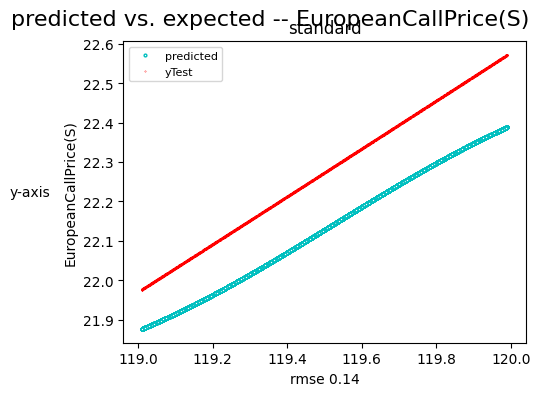

In [7]:
### 
### Single level Monte Carlo Learning (as reference for multilevel Monte Carlo Learning below)
###

###
### 0. Import packages and references
###
### Import framework
import os
mainDirectory = os.path.abspath(os.path.join(os.getcwd(), '..', '..','..'))
packageFile = os.path.abspath(os.path.join(mainDirectory, 'montecarlolearning', 'packages.py'))
exec(open(packageFile).read())

###
### 1. Set Generator: Single-level with Euler-Maruyama and h = 2^(-4) step-width	
###
Generator = Multilevel_GBM(Multilevel_Train_Case.Euler, 4)
Generator.set_inputName('S')
Generator.set_outputName('EuropeanCallPrice(S)')

###
### 2. Set Nueral network structure / 
# Hyperparameters
### 

Regressor = Neural_Approximator()
Regressor.set_Generator(Generator)
Regressor.set_hiddenNeurons(20)
Regressor.set_hiddenLayers(2)
Regressor.set_activationFunctionsHidden(tf.nn.sigmoid)
Regressor.set_activationFunctionOutput(tf.nn.sigmoid)
Regressor.set_weight_seed(1)

TrainSettings = TrainingSettings()
TrainSettings.useExponentialDecay(0.01, 0.1, 1000)
TrainSettings.set_min_batch_size(1)
TrainSettings.set_test_frequency(500)
TrainSettings.set_nTest(10000)
TrainSettings.set_samplesPerStep(10000)
TrainSettings.set_trainingSteps(1000)

###
### 3. Train network and Study results
### Comment: For different trainingSetSizes the neural network reset and not saved, hence train and evaluation of yPredicted are done together currently
###

xTest, yTest, yPredicted = train_and_test(Generator, Regressor, TrainSettings)
plot_results("predicted vs. expected", yPredicted, xTest, yTest, Generator)

RMSE after 500 training steps is [5.27085455]
RMSE after 1000 training steps is [5.30799481]
RMSE after training is [5.30799481]
max error  after training is [5.45355583]
RMSE after 500 training steps is [19.9677064]
RMSE after 1000 training steps is [19.94401553]
RMSE after training is [19.94401553]
max error  after training is [20.24283339]
RMSE after 500 training steps is [20.79658042]
RMSE after 1000 training steps is [20.75214186]
RMSE after training is [20.75214186]
max error  after training is [21.05368938]
RMSE after 500 training steps is [21.46697841]
RMSE after 1000 training steps is [21.44715179]
RMSE after training is [21.44715179]
max error  after training is [21.74697141]
RMSE after 500 training steps is [21.83981599]
RMSE after 1000 training steps is [21.83672624]
RMSE after training is [21.83672624]
max error  after training is [22.13661442]


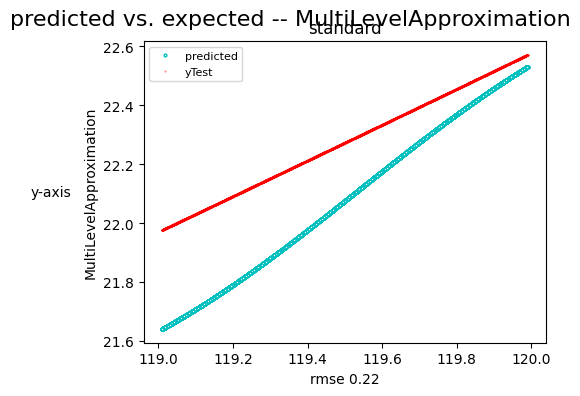

In [28]:
###
### Multi-level Monte Carlo Learning 
###

# Train level 0 with Milstein and h = 2^(0) step-width
Generator = Multilevel_GBM(Multilevel_Train_Case.Milstein, 0)
Generator.set_inputName('S')
Generator.set_outputName('MultiLevelApproximation')
# Train level 1 (level estimator) with Milstein and h_fine = 2^(-1) and h_coarse = 2^(0)
GeneratorLevel1 = Multilevel_GBM(Multilevel_Train_Case.LevelEstimator, 0)
GeneratorLevel1 .set_inputName('x')
GeneratorLevel1 .set_outputName('P_1-P_0')
# Train level 2 (level estimator) with Milstein and h_fine = 2^(-2) and h_coarse = 2^(-1)
GeneratorLevel2 = Multilevel_GBM(Multilevel_Train_Case.LevelEstimator, 1)
GeneratorLevel2 .set_inputName('x')
GeneratorLevel2 .set_outputName('P_2-P_1')
# Train level 3 (level estimator) with Milstein and h_fine = 2^(-3) and h_coarse = 2^(-2)
GeneratorLevel3 = Multilevel_GBM(Multilevel_Train_Case.LevelEstimator, 2)
GeneratorLevel3 .set_inputName('x')
GeneratorLevel3 .set_outputName('P_3-P_2')
# Train level 4 (level estimator) with Milstein and h_fine = 2^(-4) and h_coarse = 2^(-3)
GeneratorLevel4 = Multilevel_GBM(Multilevel_Train_Case.LevelEstimator, 3)
GeneratorLevel4 .set_inputName('x')
GeneratorLevel4 .set_outputName('P_4-P_3')


###
### 2. Set Nueral network structure / Hyperparameters
### 

Regressor = Neural_Approximator()
Regressor.set_Generator(Generator)
Regressor.set_hiddenNeurons(20)
Regressor.set_hiddenLayers(2)
Regressor.set_activationFunctionsHidden(tf.nn.sigmoid)
Regressor.set_activationFunctionOutput(tf.nn.sigmoid)
Regressor.set_weight_seed(1)

TrainSettings = TrainingSettings()
TrainSettings.useExponentialDecay(0.01, 0.1, 1000)
TrainSettings.set_min_batch_size(1)
TrainSettings.set_test_frequency(500)
TrainSettings.set_nTest(10000)
TrainSettings.set_samplesPerStep(40000)
TrainSettings.set_trainingSteps(1000)

###
### 3. Train and test
### Comment: For different trainingSetSizes the neural network reset and not saved, hence train and evaluation of yPredicted are done together currently
###

xTest, yTest, yPredicted = train_and_test(Generator, Regressor, TrainSettings)
TrainSettings.set_samplesPerStep(10000)
TrainSettings.useExponentialDecay(0.01, 0.1, 500)
xTest2, yTest2, yPredictedLevel1 = train_and_test(GeneratorLevel1, Regressor, TrainSettings)
TrainSettings.set_samplesPerStep(10000)
xTest, yTest, yPredictedLevel2 = train_and_test(GeneratorLevel2, Regressor, TrainSettings)
TrainSettings.set_samplesPerStep(10000)
xTest, yTest, yPredictedLevel3 = train_and_test(GeneratorLevel3, Regressor, TrainSettings)
xTest, yTest, yPredictedLevel4 = train_and_test(GeneratorLevel4, Regressor, TrainSettings)

# Add all levels for test data
multilevel_predicted = {('standard', 10000): np.add(yPredicted[('standard', 10000)], yPredictedLevel1[('standard', 10000)])}
multilevel_predicted = {('standard', 10000): np.add(multilevel_predicted[('standard', 10000)], yPredictedLevel2[('standard', 10000)])}
multilevel_predicted = {('standard', 10000): np.add(multilevel_predicted[('standard', 10000)], yPredictedLevel3[('standard', 10000)])}
multilevel_predicted = {('standard', 10000): np.add(multilevel_predicted[('standard', 10000)], yPredictedLevel4[('standard', 10000)])}

# Plot P_0 + [P_1-P_0] + [P_2-P_1] + [P_3-P_2] + [P_4-P_3]
plot_results("predicted vs. expected", multilevel_predicted, xTest, yTest, Generator)